Actions each agent have to decide between: Leave or Stay 

In [36]:
import numpy as np

class Agent: 
    def __init__(self, strategy = 1, nr_concerts = int, festival_duration=int, dynamic_strategy=str):
        self.dist_from_stage = 0
        self.position_utility = 0
        self.waiting_utility_history = np.zeros(festival_duration)
        self.waited_time = 0
        self.strategy = strategy
        self.position_utility_history = np.zeros(festival_duration)
        self.concert_history = np.ones(festival_duration, dtype=int)*(nr_concerts-1)
        self.concert_history[0] = 0 #start at first concert 
        if not isinstance(strategy, str):
            self.time_to_leave = strategy
        else:
            self.time_to_leave = np.random.choice([1,2,3,4,5]) # dynamic strategies have a random first action
        self.dynamic_strategy = dynamic_strategy
    
class Concert:
    def __init__(self, len_rows = int, capacity = 10, duration = int, nr_of_agents = int):
        self.len_rows = len_rows
        self.nr_agents = 0
        self.nr_waiting_agents = 0
        self.capacity = capacity
        self.nr_rows = np.ceil(capacity/len_rows)
        self.duration = duration 
        self.agents = np.zeros(nr_of_agents)

    def add_agent(self):
        self.nr_agents += 1

def get_dist_from_stage(concert):
    dist_from_stage = np.floor((concert.nr_agents) / concert.len_rows)
    return dist_from_stage

def get_placement_utility(concert):
    placement_factor = 5
    dist_from_stage = get_dist_from_stage(concert)
    utility = placement_factor * (concert.nr_rows - dist_from_stage) / concert.nr_rows
    return utility, dist_from_stage

def get_waiting_utility():
    waiting_factor = 1
    utility = -1 * waiting_factor
    return utility



Dynamic strategies depend on where the agent is currently placed

In [37]:
def get_dynamic_action(agent, nr_rows):
    new_time_to_leave = agent.time_to_leave #same time as last round

    # If in the lower half it goeas one timestep earlier than before, if in front half it
    # stayes as long as possible
    if (agent.dynamic_strategy == 'Slow Improver'):
        default_time_to_leave = 5
        if (agent.dist_from_stage > nr_rows / 3): # needs to go earlier to get a better place
            if agent.time_to_leave > 0: #it is possible to go earlier next time
                new_time_to_leave = agent.time_to_leave - 1
        else: #returns to default time to leave
            new_time_to_leave = default_time_to_leave
        return new_time_to_leave

    # If in the lower half it leavs one timestep earlier than before, if in front half it leaves
    # one timestep later than before
    if (agent.dynamic_strategy == 'Slow Adjuster'):
        if (agent.dist_from_stage > nr_rows / 3): # needs to go earlier to get a better place
            if agent.time_to_leave > 0: #it is possible to go earlier next time
                new_time_to_leave = agent.time_to_leave - 1
            else:
                new_time_to_leave = 1
        else: # it is in the front half, then it can stay a bit longer    
            if agent.time_to_leave < 5: 
                new_time_to_leave = agent.time_to_leave + 1
            else: 
                new_time_to_leave = 5
        return new_time_to_leave

    # Wants to get as far in front in concerts as possible, and stays as long as possible if 
    # in a good position, that is it risks the next concert
    if (agent.dynamic_strategy == 'Risk-Taker'):
        default_time_to_leave = 5
        if (agent.dist_from_stage > nr_rows / 3): # needs to leave earlier to get a better place
            new_time_to_leave = 1
        else: # happy at the front
            new_time_to_leave = default_time_to_leave
        return new_time_to_leave
    
    if (agent.dynamic_strategy == '24mix'):
        new_time_to_leave = np.random.choice([1,2,3,4,5], p=[0, 0.5, 0, 0.5, 0])
        return new_time_to_leave
    
    

Inintialize variables

In [38]:
nr_of_agents = 1000
nr_concerts = 20
nr_rows = nr_of_agents*0.1
concert_duration = 5
move_forward_option = False
mistake_rate = 0

# Available dynamic strategies
defined_dynamic_startegies = ['Slow Improver', 'Slow Adjuster', 'Risk-Taker', '24mix']
strategies = [1,2,3,4,5, '24mix', 'Slow Improver', 'Slow Adjuster', 'Risk-Taker']
probabilities = []
dynamic_strategies = []
for strategy in strategies:
    if type(strategy) == str:
        if strategy not in defined_dynamic_startegies:
            raise print("Incorrect dynamic strategy: ", strategy)

    probabilities.append(1/len(strategies))
    if type(strategy) == int:
        dynamic_strategies.append('-')
    else:
        dynamic_strategies.append(strategy)

# Set specific starting proportions if needed
#probabilities = [0.8, 0.05, 0.05, 0.05, 0.05]
#probabilities = [0.2/5, 0.2/5, 0.2/5, 0.2/5, 0.2/5, 0.8]

In [39]:
def move_agent_to_next_concert(agent, idx, current_concert, next_concert, timestep, global_time):
    timesteps_left = current_concert.duration-timestep
    # Fill up agent's waiting utilities until the next concert
    for k in range(0,timesteps_left-1):
        agent.waiting_utility_history[global_time+k] = get_waiting_utility()
        agent.waited_time -= 1
    
    # Find position utility at next concert, add to history
    position_utility, dist_from_stage = get_placement_utility(next_concert)
    agent.position_utility = position_utility
    agent.dist_from_stage = dist_from_stage
    agent.position_utility_history[global_time + timesteps_left-1] = position_utility

    # Populate the next concert
    next_concert.add_agent() 
    next_concert.agents[idx] = 1

Initialize agents and concerts

In [40]:
festival_duration = nr_concerts*concert_duration
agents = []
concerts = []

for _ in range (nr_of_agents):
    strategy_idx = np.random.choice(len(strategies), p=probabilities)
    strategy_sample = strategies[strategy_idx]
    if (type(strategy_sample) == str):
        agent = Agent(strategy = strategy_sample, 
                    nr_concerts=nr_concerts, festival_duration = festival_duration, 
                    dynamic_strategy=strategy_sample)
    else: 
        agent = Agent(strategy = strategy_sample, 
                    nr_concerts=nr_concerts, festival_duration = festival_duration, 
                    dynamic_strategy='-')
    agents.append(agent)

for _ in range(nr_concerts):
    concert = Concert(capacity = nr_of_agents, len_rows=nr_of_agents/nr_rows,
                      duration = concert_duration, nr_of_agents = nr_of_agents)
    concerts.append(concert)

#Add all agents to the starting concerts in a random order
shuffled_indices = np.random.permutation(nr_of_agents)
for i in range (nr_of_agents):
    idx = shuffled_indices[i]
    position_utility = 0 #Starting utility is zero
    concerts[0].add_agent() 
    concerts[0].agents[idx] = 1
    agents[idx].position_utility = position_utility
    concerts[0].add_agent() 



Start the festival simulation

In [41]:
global_time = 0
for concert_idx in range(0,len(concerts)-1):
    current_concert = concerts[concert_idx]
    next_concert = concerts[concert_idx + 1]

    if (concert_idx > 0):
        for agent in agents:
            if (agent.dynamic_strategy != '-'): #it has a dynamic strategy
                new_time_to_leave = get_dynamic_action(agent, current_concert.nr_rows)
                agent.time_to_leave = new_time_to_leave
            else:
                agent.time_to_leave = agent.strategy

            # Agents can make mistakes on when to leave
            if (np.random.rand() <= mistake_rate):
                agent.time_to_leave = np.random.randint(1, current_concert.duration+1)

            agent.waited_time = 0

    for timestep in range(0,current_concert.duration):
        # Update time
        global_time += 1
        nr_agents_leaving = 0
        staying_agents = []

        shuffled_indices = np.random.permutation(nr_of_agents)
        for j in range (nr_of_agents):
            idx = shuffled_indices[j]
            
            if (current_concert.agents[idx] == 0):  
                # Not attending the concert 
                continue

            # Get action
            if (agents[idx].time_to_leave == timestep+1):
                action = 'leave'
            else: 
                action = 'stay'
            
            if (action == 'leave'):
                # Leave current concert
                current_concert.agents[idx] = 0
                nr_agents_leaving += 1
                
                for k in range(0,current_concert.duration-timestep):
                    #Update agent's concert history
                    agents[idx].concert_history[global_time + k] = concert_idx + 1

                # Set agent up at the next concert
                move_agent_to_next_concert(agents[idx], idx, current_concert, next_concert, timestep, global_time)
                
            else: #they stay at the concert one more time step
                
                #Store staying agents
                staying_agents.append(idx)

        # Sort staying_agnets based on the current agents[idx].position_utility (descending)
        # In that way agents in the back can't move past agents in the front
        staying_agents.sort(key=lambda idx: agents[idx].position_utility, reverse=True)  #can take time, but needed if move_forward_option = True

        # Update position utility for agents that stay
        current_concert.nr_agents = 0
        for idx in staying_agents:
            if move_forward_option:
                position_utility, dist_from_stage = get_placement_utility(current_concert)
                agents[idx].position_utility = position_utility
            current_concert.add_agent()
        
            # Improve position utility
            agents[idx].position_utility_history[global_time] = agents[idx].position_utility
            
            #Update agent's concert history
            agents[idx].concert_history[global_time] = concert_idx 
                
    # Let all agents stay at the last concert
    if (concert_idx == nr_concerts-2):
        for agent in agents:
            for k in range(0,next_concert.duration):
                agent.position_utility_history[global_time+k] = agent.position_utility
            

Plotting of results

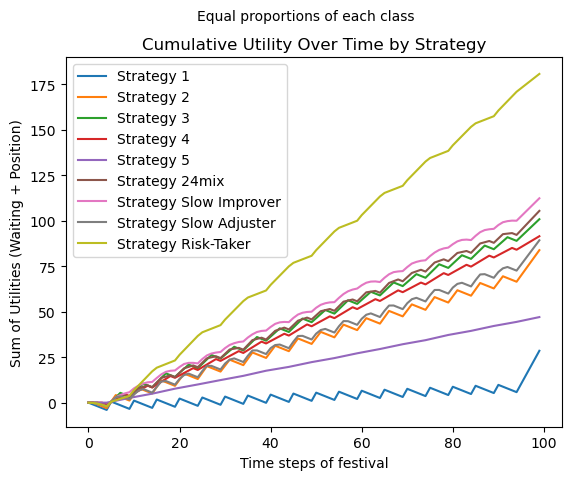

In [ ]:
import matplotlib.pyplot as plt

for agent in agents:
    agent.waiting_utility_history = np.cumsum(agent.waiting_utility_history)
    agent.position_utility_history = np.cumsum(agent.position_utility_history)
    
# Group agents by strategy
agents_by_strategy = {strategy: [agent for agent in agents if agent.strategy == strategy] for strategy in strategies}

sum_utilities = {strategy: np.zeros(festival_duration) for strategy in strategies}

# Calculate cumulative utilities for each strategy
for strategy, agent_list in agents_by_strategy.items():
    for agent in agent_list:
        sum_utilities[strategy] += agent.waiting_utility_history + agent.position_utility_history
    if len(agent_list) > 0:  # Normalize only if there are agents with this strategy
        sum_utilities[strategy] /= len(agent_list)

# Plot the utilities
timesteps = np.arange(festival_duration)
for strategy, utility in sum_utilities.items():
    plt.plot(timesteps, utility, label=f"Strategy {strategy}")

rounded_probabilities = [round(p, 3) for p in probabilities]
plt.xlabel("Time steps of festival")
plt.ylabel("Sum of Utilities (Waiting + Position)")
plt.title("Cumulative Utility Over Time by Strategy")
if mistake_rate != 0:
    plt.suptitle("Mistake-rate: " + str(int(mistake_rate*100)) + '%', fontsize = 10)
else:
    plt.suptitle("Equal proportions of each class", fontsize = 10)  
plt.legend()
plt.show()


In [43]:
# from graphs import BarGraph
# A = np.zeros([nr_concerts, int(festival_duration)])

# agent_concert = []

# # Make dataset
# for agent in agents:
#     agent_concert.append(agent.concert_history)

# for agent in agent_concert:
#     t = 0
#     for i in agent:
#         A[i, t] += 1
#         t += 1

# graph = BarGraph(A)
# graph.plot_data(5)